In [1]:
# import math
import pickle
from pathlib import Path

import PIL
import PIL.Image
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

2025-03-22 10:45:33.576440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 10:45:33.586940: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 10:45:33.695139: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 10:45:33.809116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 10:45:33.893407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
def load_dataset(dataset_path, filename):
    x, y = [], []

    for class_folder in dataset_path.iterdir():
        if class_folder.is_dir():
            for f in class_folder.iterdir():
                if f.is_file() and f.suffix.lower() == ".png":
                    try:
                        img = PIL.Image.open(f).convert('L')
                    except PIL.UnidentifiedImageError:
                        continue
                    img_array = np.array(img)
                    img_array = img_array / 255.0

                    x.append(img_array)
                    y.append(class_folder.name)

    x = np.array(x)
    y = np.array(y)

    with open(f'{filename}.pickle', 'wb') as f:
        pickle.dump((x, y), f)
    return x, y

In [3]:
def load_pickle(file_name):
    with open(f'{file_name}.pickle', 'rb') as f:
        x, y = pickle.load(f)
    return x, y

In [4]:
# x_test, y_test = load_dataset(Path("/home/user/Education/ML/lab1/notMNIST_small"), "small")

In [5]:
# x, y = load_dataset(Path("/home/user/Education/ML/lab1/notMNIST_large"), "large")

In [6]:
train_size = 200000
validation_size = 10000

In [7]:
def preprocess_data():
    x_test, y_test = load_pickle("small")
    x, y = load_pickle("large")

    print(x.shape)

    x_train, x_val, y_train, y_val = train_test_split(
        x,
        y,
        test_size=validation_size,
        train_size=train_size,
        random_state=42,
        stratify=y
    )

    print(x_train.shape)

    x_train = x_train.reshape((len(x_train), 28, 28, 1))
    x_val = x_val.reshape((len(x_val), 28, 28, 1))
    x_test = x_test.reshape((len(x_test), 28, 28, 1))

    return x_train, x_val, x_test, y_train, y_val, y_test

In [8]:
def transform_labels(y_train, y_val, y_test):
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    y_val = label_encoder.fit_transform(y_val)
    
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    y_val = tf.keras.utils.to_categorical(y_val)

    return y_train, y_val, y_test

In [9]:
def show_history_plot(history):
    fig = plt.figure(figsize=(15, 4))

    fig.add_subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')

    fig.add_subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training loss', 'Validation loss'])
    plt.title('Training and validation loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.show()

# Задание 1. Два сверточных слоя

In [10]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_data()

(529114, 28, 28)
(200000, 28, 28)


In [11]:
y_train, y_val, y_test = transform_labels(y_train, y_val, y_test)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,359,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,378,826 (9.07 MB)

 Trainable params: 2,378,826 (9.07 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(200000, 28, 28, 1) (200000, 10)
(18724, 28, 28, 1) (18724, 10)
(10000, 28, 28, 1) (10000, 10)


Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 90s 14ms/step - accuracy: 0.8007 - loss: 0.6985 - val_accuracy: 0.8899 - val_loss: 0.3712
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 90s 14ms/step - accuracy: 0.8904 - loss: 0.3753 - val_accuracy: 0.9015 - val_loss: 0.3244
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 90s 14ms/step - accuracy: 0.9050 - loss: 0.3189 - val_accuracy: 0.9073 - val_loss: 0.3033
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - accuracy: 0.9119 - loss: 0.2918 - val_accuracy: 0.9125 - val_loss: 0.2981
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 91s 15ms/step - accuracy: 0.9188 - loss: 0.2679 - val_accuracy: 0.9112 - val_loss: 0.2937
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 91s 15ms/step - accuracy: 0.9250 - loss: 0.2503 - val_accuracy: 0.9131 - val_loss: 0.2932
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 91s 15ms/step - accuracy: 0.9281 - loss: 0.2355 - val_accuracy: 0.9145 - val_loss: 0.2841
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 93s 15ms/step - accuracy: 0.9330 -

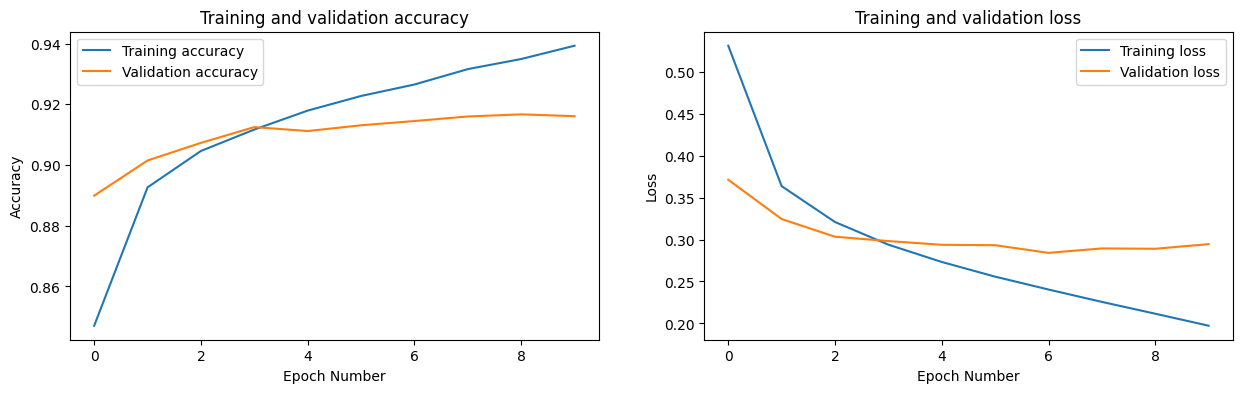

In [16]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val)
)
show_history_plot(history)

In [17]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Classification accuracy on test set: ', test_acc)

586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9579 - loss: 0.1469
Classification accuracy on test set:  0.961653470993042


# Задание 2. Два слоя, реализующие операцию пулинга (Pooling)

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_data()

In [ ]:
y_train, y_val, y_test = transform_labels(y_train, y_val, y_test)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,850 (15.04 KB)

 Trainable params: 3,850 (15.04 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 636us/step - accuracy: 0.6515 - loss: 1.2391 - val_accuracy: 0.7950 - val_loss: 0.7671
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 626us/step - accuracy: 0.7899 - loss: 0.7655 - val_accuracy: 0.8054 - val_loss: 0.7105
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 632us/step - accuracy: 0.7980 - loss: 0.7173 - val_accuracy: 0.8100 - val_loss: 0.6812
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 631us/step - accuracy: 0.8030 - loss: 0.6893 - val_accuracy: 0.8121 - val_loss: 0.6568
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 625us/step - accuracy: 0.8069 - loss: 0.6712 - val_accuracy: 0.8123 - val_loss: 0.6426
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 622us/step - accuracy: 0.8098 - loss: 0.6513 - val_accuracy: 0.8146 - val_loss: 0.6273
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 635us/step - accuracy: 0.8111 - loss: 0.6428 - val_accuracy: 0.8159 - val_loss: 0.6150
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 630us/step - accuracy: 0.8149 -

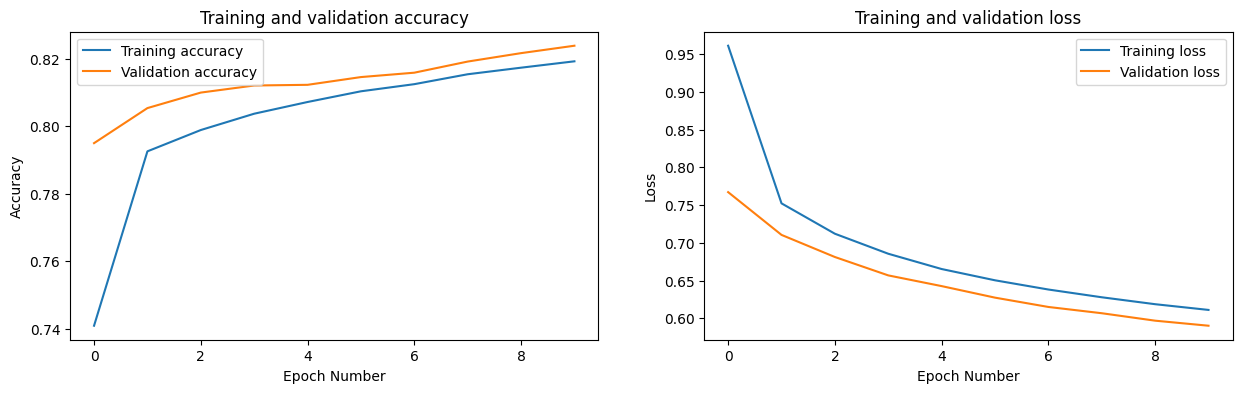

In [21]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val)
)
show_history_plot(history)

In [22]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Classification accuracy on test set: ', test_acc)

586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.8793 - loss: 0.4142
Classification accuracy on test set:  0.8839991688728333


Точность полученной модели, с двумя слоями, реализующими операцию пулинга, состовляет 88% за 10 эпох. В сравнении с моделью из задания 1, которая содержит два сверточных слоя и точность составляет 96%, точность уменьшилась. Это связанно с тем, что операция подвыборки только уменьшает изображение и обрабатывает уже найденные признаки. Данная операция позволяет сделать модель более устойчивой и уменьшить время обучения, поэтому каждая эпоха этой модели занимала около 4 секунд, когда у первой около 1:30 минуты

# Задание 3. LeNet-5

In [27]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_data()

(529114, 28, 28)
(200000, 28, 28)


In [28]:
x_train.shape

(200000, 28, 28, 1)

In [29]:
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant')

In [30]:
x_train.shape

(200000, 32, 32, 1)

In [31]:
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant')
x_val = np.pad(x_val, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant')

In [32]:
y_train, y_val, y_test = transform_labels(y_train, y_val, y_test)

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 1)),
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='tanh'),
    tf.keras.layers.AveragePooling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),
    tf.keras.layers.AveragePooling2D((2,2)),
    tf.keras.layers.Conv2D(120, kernel_size=(5, 5), activation='tanh'),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(120, activation='tanh'),
    tf.keras.layers.Dense(84, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7572 - loss: 0.9045 - val_accuracy: 0.8557 - val_loss: 0.4982
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8575 - loss: 0.4872 - val_accuracy: 0.8752 - val_loss: 0.4163
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8741 - loss: 0.4250 - val_accuracy: 0.8840 - val_loss: 0.3765
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8848 - loss: 0.3858 - val_accuracy: 0.8946 - val_loss: 0.3494
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8912 - loss: 0.3645 - val_accuracy: 0.8972 - val_loss: 0.3346
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8975 - loss: 0.3408 - val_accuracy: 0.8984 - val_loss: 0.3280
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8999 - loss: 0.3328 - val_accuracy: 0.9043 - val_loss: 0.3130
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9027 - loss: 0

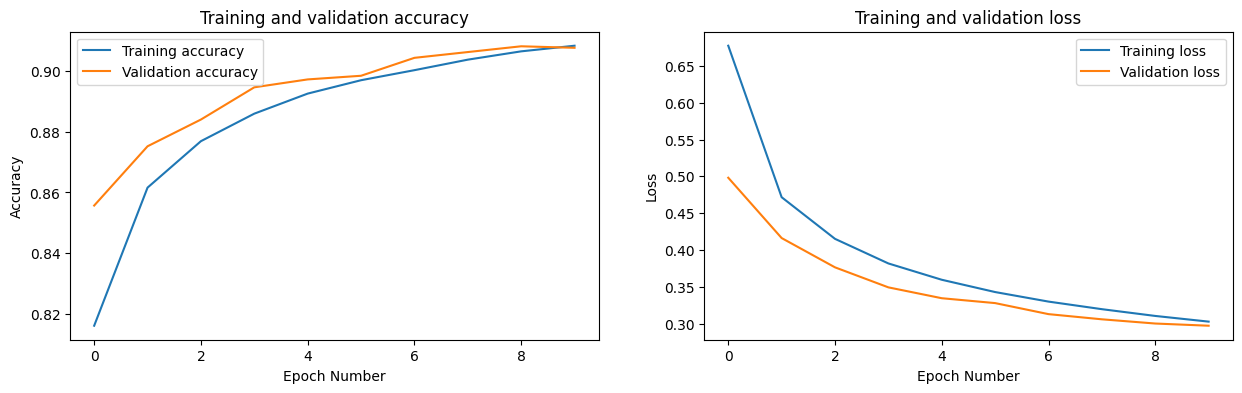

In [36]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val)
)
show_history_plot(history)

In [37]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Classification accuracy on test set: ', test_acc)

586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9516 - loss: 0.1626
Classification accuracy on test set:  0.9558854699134827


Точность данной модели составила 95,5% после 10 эпох. Это немного меньше, чем у первой модели (96%). Однако качество обучения выше. В данной модели помимо сверточных слоев присутствуют операции пулинга. За счет этого время обучения одной эпохи составило примерно 16 секунд. А между результатами обучающей и валидационной выборки нет больших различий в сравнении с первой моделью.

# Сравнение моделей

- **логистическа регрессия - 89%**

- **базовая полносвязная нейронная сеть**

  Training set accuracy: 0.9209 - loss: 0.2715

  Validation set accuracy: 0.9038 - val_loss: 0.3285

  Classification accuracy on test set: 0.9519333243370056 - loss: 0.1719

- **полносвязная нейронная сеть с регуляризацией и сбросом нейронов**

  Training set accuracy: 0.8994 - loss: 0.7340

  Validation set accuracy: 0.8987 - val_loss: 0.7215

  Classification accuracy on test set: 0.9490493535995483 - loss: 0.5830

- **полносвязная нейронная сеть с регуляризацией, сбросом нейронов и динамической скоростью обучения**

  Training set accuracy: 0.9266 - loss: 0.3532

  Validation set accuracy: 0.9125 - val_loss: 0.3981

  Classification accuracy on test set: 0.9587695002555847 - loss: 0.2692

- **CNN - Два сверточных слоя**

  Training set accuracy: 0.9418 - loss: 0.1912

  Validation set accuracy: 0.9161 - val_loss: 0.2945

  Classification accuracy on test set:  0.961653470993042

- **CNN - Два слоя, реализующие операцию пулинга (Pooling)**

  Training set accuracy: 0.8182 - loss: 0.6140

  Validation set accuracy: 0.8239 - val_loss: 0.5901

  Classification accuracy on test set:  0.8839991688728333

- **LeNet-5**

  Training set accuracy: 0.9087 - loss: 0.3023

  Validation set accuracy: 0.9076 - val_loss: 0.2973

  Classification accuracy on test set:  0.9558854699134827
